# Stock market forecast

We are going to use the historical price dataset of the Apple (AAPL) stock downloaded from Yahoo Finance. This dataset contains daily stock market information, which will allow us to make a time series forecast.

We will use historical stock market information from January 1, 2015 to January 1, 2024.

### This dataset contains this information:

1. **Columns**:
   - **Date**: The date corresponding to each record.
   - **Open**: The opening price of the stock on the specified date.
   - **High**: The highest price at which the stock was traded on the specified date.
   - **Low**: The lowest price at which the stock was traded on the specified date.
   - **Close**: The closing price of the stock on the specified date. This is the price most commonly used for analysis and forecasting.
   - **Adj Close**: The adjusted closing price. This price adjusts the closing price according to corporate events such as dividends, stock splits and new stock issuances, providing a more accurate view of the actual value of the stock.
   - **Volume**: The number of shares traded during the specified date.

### The objective is to:
**To perform the Apple stock price prediction for the next day based on historical information.**

# **Warning**:
**This notebook is for educational purposes only NOT investment advice.**

In [1]:
# Import libreries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

## Download the database

In [2]:
# Download Apple stock market data
data_apple = yf.download('AAPL', start='2015-01-01', end='2024-01-01')

# Display the first 10 data
data_apple.head(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373959,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687305,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689537,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021719,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944681,237458000
2015-01-09,28.167500,28.312500,27.552500,28.002501,24.971437,214798000
2015-01-12,28.150000,28.157499,27.200001,27.312500,24.356125,198603200
2015-01-13,27.857500,28.200001,27.227501,27.555000,24.572374,268367600
2015-01-14,27.260000,27.622499,27.125000,27.450001,24.478739,195826400


In [3]:
data_apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2264 non-null   float64
 1   High       2264 non-null   float64
 2   Low        2264 non-null   float64
 3   Close      2264 non-null   float64
 4   Adj Close  2264 non-null   float64
 5   Volume     2264 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 123.8 KB


In [4]:
data_apple.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2264.000000,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03
mean,83.956509,84.876609,83.092088,84.026440,81.852793,1.237607e+08
std,55.979856,56.611354,55.396020,56.034699,56.305992,6.818458e+07
min,22.500000,22.917500,22.367500,22.584999,20.720034,2.404830e+07
25%,35.452501,35.651249,35.243749,35.439376,32.999371,7.831732e+07
50%,54.039999,54.740000,53.270000,53.868752,51.509111,1.056556e+08
75%,141.444996,143.274998,139.239998,141.710003,139.800014,1.486811e+08
max,198.020004,199.619995,197.000000,198.110001,197.361084,6.488252e+08


## Data Preparation
To perform time series forecasting, we will focus on the `Close` (closing price) column, as it is the most commonly used for this type of analysis.

We need to scale the data, and also divide into training, validation and testing.

In [6]:
# Data preparation
price_close = data_apple['Close'].values.reshape(-1, 1)

In [7]:
# Data standardization
scaler = StandardScaler()
price_close_scaled = scaler.fit_transform(price_close)

In [8]:
# Create: training set 70%, validation 15% and test 15%.
# DO NOT use train_test_split -> mix the data and WE DON'T WANT THAT

size = len(price_close_scaled)
train_size = int(size * 0.7)
val_size = int(size * 0.15)
test_size = size - train_size - val_size

# Create training, validation and test sets
train_set = price_close_scaled[:train_size]
val_set = price_close_scaled[train_size:train_size+val_size]
test_set = price_close_scaled[train_size+val_size:]

In [9]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

1584
339
341


Let's create a function that prepares the data to be used in a time series prediction model.

In [10]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

### Example of using the `create_dataset` function.
Suppose we have the following data from a time series:

In [11]:
data_example = np.array([[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]])
data_example

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

And we use the `create_dataset` function with a `time_step` of 3:

In [12]:
X_example, y_example = create_dataset(data_example, time_step=3)

The result will be:

In [13]:
print('X: \n',X_example)
print('y: ',y_example)

X: 
 [[1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]]
y:  [4 5 6 7 8 9]


### Explanation of the result
`X_example` contains the 3-step sequences (time windows) that are used as inputs to the model.
`y_example` contains the next value in the time series for each of these sequences.

💡 Tip:

Try different values of `time_step` and observe the results to better understand the function.

## Let's test with a 5-day time window.

In [14]:
# Create dataset with a time window of 5 days
time_step = 5
X_train_, y_train = create_dataset(train_set, time_step)
X_val_, y_val = create_dataset(val_set, time_step)

We must resize the data to be compatible with the LSTM input. `[samples, time steps, features]`

In [15]:
X_train = X_train_.reshape(X_train_.shape[0], X_train_.shape[1], 1)
X_val = X_val_.reshape(X_val_.shape[0], X_val_.shape[1], 1)

In [16]:
X_train[0]

array([[-1.01198838],
       [-1.0257329 ],
       [-1.02568827],
       [-1.01903914],
       [-1.00056437]])

In [17]:
y_val[0]

0.8989909179429956

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(1578, 5, 1)
(1578,)
(333, 5, 1)
(333,)


## Creation of the LSTM model

In [19]:
# Let's try a 2-layer model with 50 LSTM cells.
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 💡 Clarification
Let's explain why `return_sequences=True` is used in the first hidden layer and `return_sequences=False` in the second hidden layer.

- **First LSTM Layer**:
  - `return_sequences=True` indicates that the layer should return the complete sequence of outputs for each input in the sequence.
  - This means that if the input has a form `(batch_size, time_step, features)`, the output will have the form `(batch_size, time_step, units)`, where `units` is the number of LSTM units in the layer (in this case, 50).

  - The first LSTM layer returns the entire sequence of outputs because the next layer is also an LSTM layer that needs to receive the entire sequence as input to process the time series information effectively.
  - By returning the entire sequence, the timing and information throughout the sequence is preserved for the next LSTM layer.

- **Second LSTM Layer**:
  - `return_sequences=False` indicates that the layer should return only the last output in the sequence.
  - This means that if the input has a form `(batch_size, time_step, units)`, the output will have the form `(batch_size, units)`.

  - The second LSTM layer does not need to return the full stream because it is the last LSTM layer before the fully connected layer.
  - Only the last output of the second LSTM layer is needed to make the final prediction in the dense layer.
  - By returning only the last output, the output dimension is reduced, which is suitable for the final dense layer that produces a single prediction per input sequence.

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# We implement an 'early_stopping' to avoid overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
           validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.3891 - val_loss: 0.3759
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0084 - val_loss: 0.0209
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - val_loss: 0.0314
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0315
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 0.0336
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0307
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013 - val_loss: 0.0305
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011 - val_loss: 0.0269
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - val_loss: 0.0271
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014 - val_loss: 0.0313
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - val_loss: 0.0275
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - lo

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

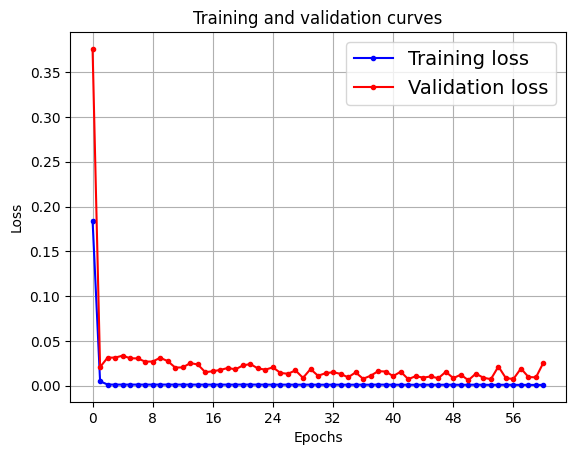

In [22]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and validation curves")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## Let's make predictions on the test set

In [24]:
# Making predictions

X_test, y_test = create_dataset(test_set, time_step)
y_pred = model.predict(X_test)

# Invert the normalization to obtain the real values.
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [25]:
# Calculate RMSE and MAE

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)

Root mean square error:  6.249631692629428
Mean absolute error:  5.211953667028626


### Let's visualize the results

In [26]:
# Prediction in the training set just for visualization
y_pred_train = model.predict(X_train_)
y_pred_train = scaler.inverse_transform(y_pred_train)

# Prediction in the validation set just for visualization
y_pred_val = model.predict(X_val_)
y_pred_val = scaler.inverse_transform(y_pred_val)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


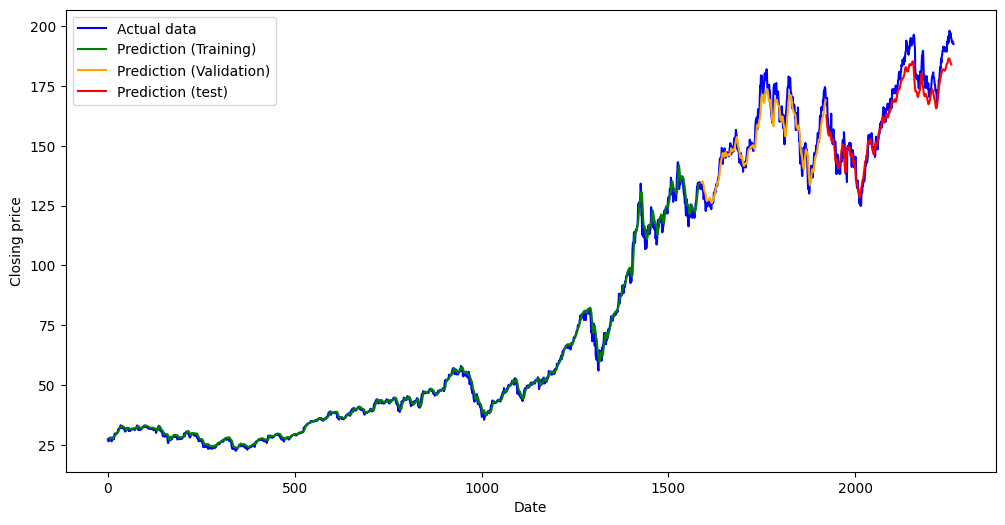

In [27]:
# Length of training and validation data
len_train = len(train_set)
len_val = len(val_set)

# Adjust 'x' to match the length of 'price_close'.
x = np.arange(len(price_close))

plt.figure(figsize=(12, 6))
plt.plot(x, price_close, 'b', label='Actual data')
plt.plot(x[time_step:time_step + len(y_pred_train)], y_pred_train, 'g', label='Prediction (Training)')
plt.plot(x[len(train_set) + time_step:len(train_set) + time_step + len(y_pred_val)], y_pred_val, 'orange', label='Prediction (Validation)')
plt.plot(x[len_train + len_val:len_train + len_val + len(y_pred)], y_pred, 'r', label='Prediction (test)')
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.legend()
plt.show()

# 💡 Tip:
* Test with different sizes in the input window.
* Test with different number of hidden layers and different number of cells per layer.
* Make prediction on the test set with the best model and plot to visualize the results.